**<h2 style="text-align: center; color:#33FF33;">CHURN WITH PURCHASE USERS</h2>**

#### **Neccessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    confusion_matrix, roc_curve, auc,
    brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Read and explore data**

#### **Read data**

In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'},parse_dates=['last_update_time'])
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_equip=pd.read_csv("../EDA_transform/data/equipenhance_transform.csv",dtype={'vopenid':'object'})

df_purchase.columns = df_purchase.columns.str.strip()
df_equip.columns = df_equip.columns.str.strip()
df_purchase['last_update_time'] = pd.to_datetime(df_purchase['last_update_time'], errors='coerce', utc=True)
df_equip['last_update_time'] = pd.to_datetime(df_equip['last_update_time'], errors='coerce', utc=True)

df_login.shape,df_purchase.shape,df_equip.shape

((199370, 17), (32120, 9), (55138, 5))

In [3]:
df_login.info(),df_login['last_update_time'].min(),df_login['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199370 entries, 0 to 199369
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   vopenid                199370 non-null  object             
 1   last_update_time       199370 non-null  datetime64[ns, UTC]
 2   num_day_login          199370 non-null  int64              
 3   avg_login_per_day      199370 non-null  float64            
 4   avg_between_login      199370 non-null  float64            
 5   streak_login           199370 non-null  int64              
 6   last_since_from_login  199370 non-null  int64              
 7   popular_time_login     199370 non-null  int64              
 8   gold_std_login         199370 non-null  float64            
 9   diamond_std_login      199370 non-null  float64            
 10  silkcoin_std_login     199370 non-null  float64            
 11  gold_slope_login       199370 non-null 

(None,
 Timestamp('2025-05-03 17:01:25+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [4]:
df_purchase.info(),df_purchase['last_update_time'].min(),df_purchase['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32120 entries, 0 to 32119
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   vopenid                   32120 non-null  object             
 1   last_update_time          32040 non-null  datetime64[ns, UTC]
 2   num_purchase              32120 non-null  int64              
 3   total_purchase            32120 non-null  float64            
 4   count_purchase_per_day    32120 non-null  float64            
 5   std_amount_purchase       32120 non-null  float64            
 6   max_purchase              32120 non-null  float64            
 7   days_since_last_purchase  32120 non-null  int64              
 8   num_product_buyed         32120 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(1)
memory usage: 2.2+ MB


(None,
 Timestamp('2025-05-03 17:06:56.892000+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:55.790000+0000', tz='UTC'))

In [5]:
df_equip.info(),df_equip['last_update_time'].min(),df_equip['last_update_time'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55138 entries, 0 to 55137
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   vopenid               55138 non-null  object             
 1   last_update_time      55138 non-null  datetime64[ns, UTC]
 2   num_enhance           55138 non-null  int64              
 3   enhance_success_rate  55138 non-null  float64            
 4   max_enhance_level     55138 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(1)
memory usage: 2.1+ MB


(None,
 Timestamp('2025-05-03 17:00:34+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:58+0000', tz='UTC'))

#### **Merge data**

In [6]:
df_login = df_login.rename(columns={'last_update_time': 'last_update_time_login'})
df_purchase = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'})
df_equip = df_equip.rename(columns={'last_update_time': 'last_update_time_equip'})

df_purchase_user = df_purchase.copy()

df_merged = df_purchase_user.merge(
    df_login, 
    on='vopenid',
    how='inner'
)
df_merged = df_merged.merge(
    df_equip.drop(columns=['last_update_time_equip']),  
    on='vopenid',
    how='left'
)

In [7]:
del df_login
del df_purchase
del df_equip

In [8]:
df_merged.head(3)

,vopenid,last_update_time_purchase,num_purchase,total_purchase,count_purchase_per_day,std_amount_purchase,max_purchase,days_since_last_purchase,num_product_buyed,last_update_time_login,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login,num_enhance,enhance_success_rate,max_enhance_level
0,2206211830166192,2025-05-24 15:48:36.757000+00:00,1,0.79,1.00,0.00,0.79,22,1,2025-05-26 03:29:48+00:00,3,5.00,0.13,3,21,9,181008.90,0.00,4.79,34524.61,0.00,0.81,265807,28,0,NaN,NaN,NaN
1,2210221534402190,2025-05-26 05:14:28.541000+00:00,1,7.88,1.00,0.00,7.88,21,1,2025-06-18 14:17:29+00:00,46,6.67,0.15,46,-3,23,1445080.52,20.47,46.87,-4278.84,-0.17,0.13,20972980,78,3,221.00,0.61,8.00
2,2210221828089318,2025-06-11 14:06:52.646000+00:00,2,3.98,2.00,0.00,1.99,4,2,2025-06-17 18:38:11+00:00,7,2.43,1.01,4,-2,22,578048.91,0.00,0.00,95838.47,0.00,0.00,465352,33,1,44.00,0.70,3.00


In [9]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32104 entries, 0 to 32103
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   vopenid                    32104 non-null  object             
 1   last_update_time_purchase  32030 non-null  datetime64[ns, UTC]
 2   num_purchase               32104 non-null  int64              
 3   total_purchase             32104 non-null  float64            
 4   count_purchase_per_day     32104 non-null  float64            
 5   std_amount_purchase        32104 non-null  float64            
 6   max_purchase               32104 non-null  float64            
 7   days_since_last_purchase   32104 non-null  int64              
 8   num_product_buyed          32104 non-null  int64              
 9   last_update_time_login     32104 non-null  datetime64[ns, UTC]
 10  num_day_login              32104 non-null  int64              
 11  av

#### **Set churn**

In [10]:
now = pd.Timestamp('2025-06-19 17:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time_login']).dt.days

In [11]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:26:29+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

In [12]:
df_merged['churn'] = (df_merged['days_since_last_login'] >= 7).astype(int) # true is one
df_merged[['vopenid','last_update_time_login','churn']].head(10)

,vopenid,last_update_time_login,churn
0,2206211830166192,2025-05-26 03:29:48+00:00,1
1,2210221534402190,2025-06-18 14:17:29+00:00,0
2,2210221828089318,2025-06-17 18:38:11+00:00,0
3,2302080453545458,2025-06-18 07:15:50+00:00,0
4,2302141307530184,2025-06-12 12:50:04+00:00,1
5,2302201232124760,2025-06-18 15:18:02+00:00,0
6,2309230721167301,2025-06-11 14:24:20+00:00,1
7,2310030708237246,2025-06-18 06:46:13+00:00,0
8,2312031227360360,2025-06-18 14:21:35+00:00,0
9,2312250012396360,2025-06-13 09:56:33+00:00,0


In [13]:
df_merged['churn'].value_counts()

churn
0    28989
1     3115
Name: count, dtype: int64

In [14]:
df_merged.columns

Index(['vopenid', 'last_update_time_purchase', 'num_purchase',
       'total_purchase', 'count_purchase_per_day', 'std_amount_purchase',
       'max_purchase', 'days_since_last_purchase', 'num_product_buyed',
       'last_update_time_login', 'num_day_login', 'avg_login_per_day',
       'avg_between_login', 'streak_login', 'last_since_from_login',
       'popular_time_login', 'gold_std_login', 'diamond_std_login',
       'silkcoin_std_login', 'gold_slope_login', 'diamond_slope_login',
       'silkcoin_slope_login', 'powerpoint_last_login', 'level_last_login',
       'vip_last_login', 'num_enhance', 'enhance_success_rate',
       'max_enhance_level', 'days_since_last_login', 'churn'],
      dtype='object')

#### **Visualize**

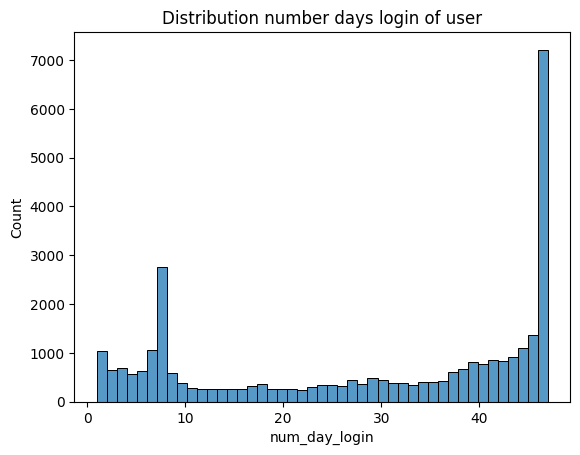

In [15]:
sns.histplot(df_merged['num_day_login'], bins=45)
plt.title('Distribution number days login of user')
plt.show()

In [16]:
df_merged['last_update_time_login'].min(),df_merged['last_update_time_login'].max()

(Timestamp('2025-05-03 17:26:29+0000', tz='UTC'),
 Timestamp('2025-06-18 16:59:59+0000', tz='UTC'))

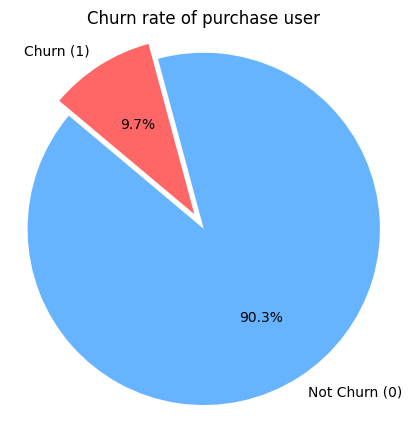

In [17]:
churn_counts = df_merged['churn'].value_counts().sort_index()
labels = ['Not Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(5,5))
plt.pie(
    churn_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=[0, 0.1]  
)
plt.title("Churn rate of purchase user")
plt.axis('equal') 
plt.show()

In [18]:
drop_cols = [
    'last_update_time_purchase',
    'last_update_time_login',
    'days_since_last_purchase',
    'days_since_last_login',
]
df_merged=df_merged.drop(columns=drop_cols,axis=1)

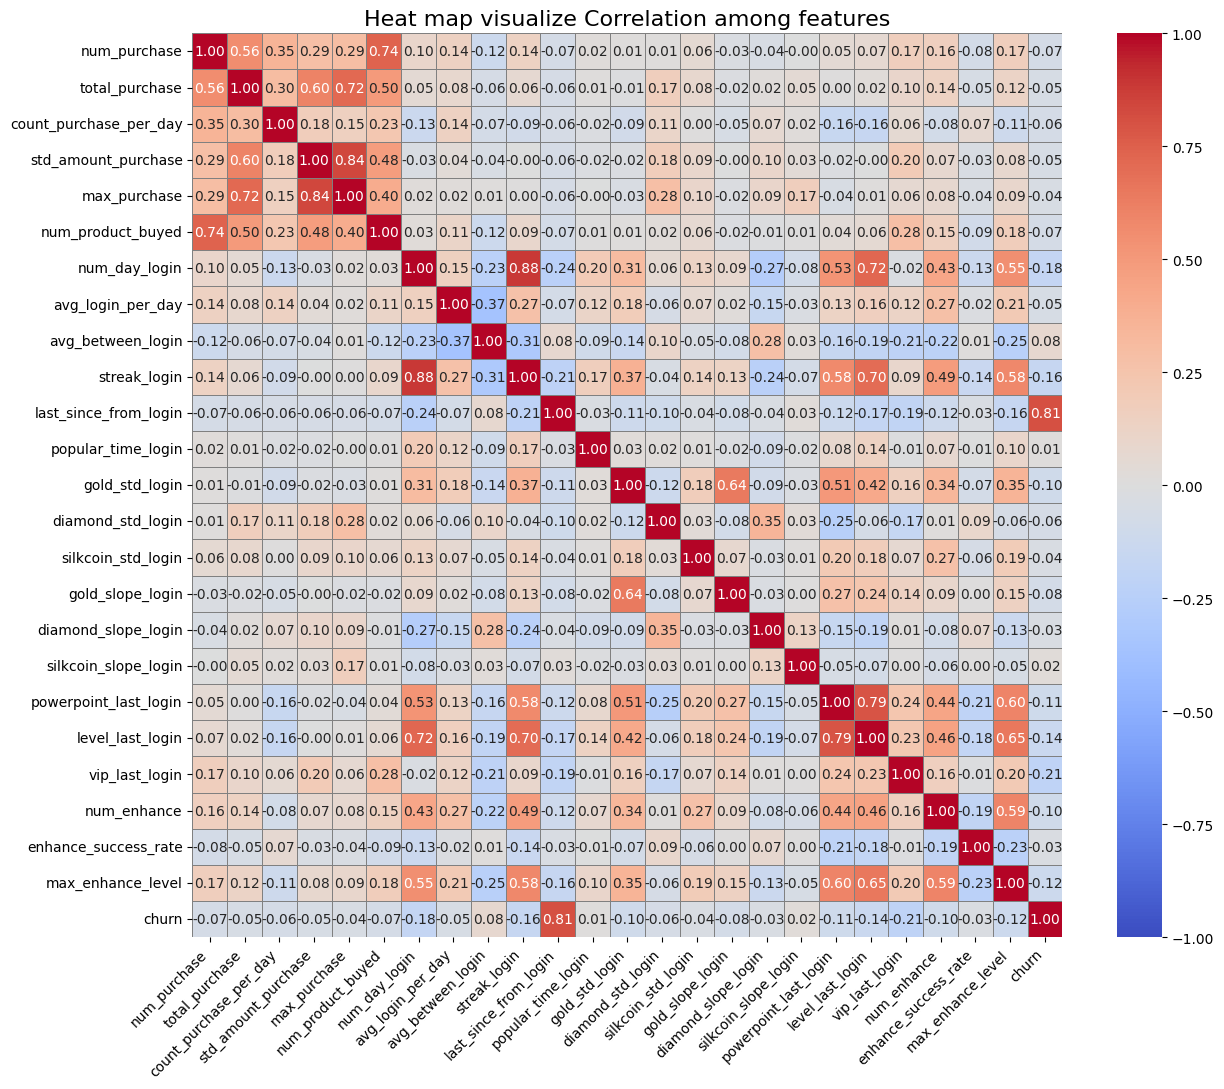

In [19]:
corr_cols = df_merged.drop(columns=['vopenid']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(13, 11))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
# corr_matrix = df_merged[corr_cols].corr()
# corr_matrix

### **Prepare data**

In [21]:
df_merged['num_enhance'] = df_merged['num_enhance'].fillna(0)
df_merged['enhance_success_rate'] = df_merged['enhance_success_rate'].fillna(0)
df_merged['max_enhance_level'] = df_merged['max_enhance_level'].fillna(0)

In [22]:
X=df_merged.drop(columns=['churn','vopenid','last_since_from_login','powerpoint_last_login'],axis=1)
y=df_merged['churn']

In [23]:
vopenid_all = df_merged['vopenid']

In [24]:
X_temp, X_train, y_temp, y_train, vopenid_temp, vopenid_train = train_test_split(
    X, y, vopenid_all,
    test_size=0.8,
    stratify=y
)

X_test, X_val, y_test, y_val, vopenid_test, vopenid_val = train_test_split(
    X_temp, y_temp, vopenid_temp,
    test_size=0.5, 
    stratify=y_temp
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, vopenid_train.shape, vopenid_test.shape

((25684, 22), (3210, 22), (25684,), (3210,), (25684,), (3210,))

In [25]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [27]:
X_train.shape,y_train.shape, X_train_scaled.shape,X_test_scaled.shape

((46384, 22), (46384,), (46384, 22), (3210, 22))

### **Modeling**

#### **Logistic Regression**

In [ ]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 16:24:15,494] A new study created in memory with name: no-name-18f4eab8-92ae-4cc9-a7a5-57be083577a8
[I 2025-06-23 16:24:17,310] Trial 0 finished with value: 0.8271854979985415 and parameters: {'C': 0.001694185511375555, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8271854979985415.
[I 2025-06-23 16:24:17,888] Trial 1 finished with value: 0.837429361598334 and parameters: {'C': 0.8229469046743234, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.837429361598334.
[I 2025-06-23 16:24:18,239] Trial 2 finished with value: 0.8357856716246437 and parameters: {'C': 0.003540324045693679, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.837429361598334.
[I 2025-06-23 16:24:20,855] Trial 3 finished with value: 0.8352823074154057 and parameters: {'C': 0.006679241903117437, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. B

Best AUC: 0.8374337772910735
  - C: 0.4575961861747018
  - penalty: l2
  - solver: liblinear
  - class_weight: balanced


In [29]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.4575961861747018, class_weight='balanced', n_jobs=-1,
                   random_state=42, solver='liblinear')

In [30]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.7411
Precision: 0.2418
Recall: 0.7788
F1-score: 0.3690
AUC-ROC: 0.8131
Log loss: 0.5346
Brier score: 0.1801

Confusion matrix:
[[2136  762]
 [  69  243]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2898
           1       0.24      0.78      0.37       312

    accuracy                           0.74      3210
   macro avg       0.61      0.76      0.60      3210
weighted avg       0.90      0.74      0.79      3210



#### **Extra Trees**

In [31]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 16:24:49,948] A new study created in memory with name: no-name-395f4c5a-918e-4a73-8ad1-7532dfb1ade9
[I 2025-06-23 16:24:53,227] Trial 0 finished with value: 0.9889100924289119 and parameters: {'n_estimators': 364, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': 0.8, 'class_weight': None}. Best is trial 0 with value: 0.9889100924289119.
[I 2025-06-23 16:24:55,607] Trial 1 finished with value: 0.9808182867532583 and parameters: {'n_estimators': 368, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9889100924289119.
[I 2025-06-23 16:24:58,480] Trial 2 finished with value: 0.9732684109226033 and parameters: {'n_estimators': 472, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9889100924289119.
[I 2025-06-23 16:25:00,983] Trial 3 finished with val

Best value: 0.9952894424514236
Best params:
  - n_estimators: 427
  - max_depth: 22
  - min_samples_split: 4
  - min_samples_leaf: 1
  - max_features: None
  - class_weight: balanced


In [32]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', max_depth=22, max_features=None,
                     min_samples_split=4, n_estimators=427, n_jobs=-1,
                     random_state=42)

In [33]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9274
Precision: 0.5980
Recall: 0.7724
F1-score: 0.6741
AUC-ROC: 0.9630
Log loss: 0.1553
Brier score: 0.0495

Confusion matrix:
[[2736  162]
 [  71  241]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2898
           1       0.60      0.77      0.67       312

    accuracy                           0.93      3210
   macro avg       0.79      0.86      0.82      3210
weighted avg       0.94      0.93      0.93      3210



#### **Random Forest**

In [34]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 16:27:32,304] A new study created in memory with name: no-name-a10db82c-99ff-4e2e-b18c-2d9846d8120d
[I 2025-06-23 16:28:32,871] Trial 0 finished with value: 0.9912825317281009 and parameters: {'n_estimators': 302, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9912825317281009.
[I 2025-06-23 16:29:36,181] Trial 1 finished with value: 0.9731922401557052 and parameters: {'n_estimators': 345, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9912825317281009.
[I 2025-06-23 16:30:04,362] Trial 2 finished with value: 0.9937488043076049 and parameters: {'n_estimators': 438, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.8, 'bootstrap': True, 'class_weight': None}. Best is trial 2 with value: 0.9937488043076049.
[I

Best value: 0.9952239529827585
Best params:
  - n_estimators: 371
  - max_depth: 27
  - min_samples_split: 11
  - min_samples_leaf: 3
  - max_features: sqrt
  - bootstrap: False
  - class_weight: balanced


In [35]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=27,
                       min_samples_leaf=3, min_samples_split=11,
                       n_estimators=371, n_jobs=-1, random_state=42)

In [36]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9308
Precision: 0.6308
Recall: 0.6955
F1-score: 0.6616
AUC-ROC: 0.9585
Log loss: 0.1598
Brier score: 0.0487

Confusion matrix:
[[2771  127]
 [  95  217]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2898
           1       0.63      0.70      0.66       312

    accuracy                           0.93      3210
   macro avg       0.80      0.83      0.81      3210
weighted avg       0.93      0.93      0.93      3210



#### **Extreme Gradient Boosting**

In [37]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1,2,5,9.3,10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 16:39:37,208] A new study created in memory with name: no-name-32ec93cc-cb32-4b5b-aa42-eb0fc8a60b97
[I 2025-06-23 16:39:39,569] Trial 0 finished with value: 0.9931814683499649 and parameters: {'max_depth': 5, 'learning_rate': 0.28853887446664844, 'gamma': 3.113970046110885, 'min_child_weight': 2, 'colsample_bytree': 0.7544451790384614, 'subsample': 0.809967306735186, 'reg_alpha': 0.2087026420942823, 'reg_lambda': 0.05292633779059114, 'scale_pos_weight': 9.3, 'n_estimators': 372}. Best is trial 0 with value: 0.9931814683499649.
[I 2025-06-23 16:39:40,410] Trial 1 finished with value: 0.9910500725714758 and parameters: {'max_depth': 4, 'learning_rate': 0.2383484240197231, 'gamma': 7.074992553072454, 'min_child_weight': 9, 'colsample_bytree': 0.6491907053711397, 'subsample': 0.9263261317755326, 'reg_alpha': 0.276462270306709, 'reg_lambda': 0.018414602338524877, 'scale_pos_weight': 5, 'n_estimators': 100}. Best is trial 0 with value: 0.9931814683499649.
[I 2025-06-23 16:39:42

Best values 0.995777212578471
Best params:
  - max_depth: 12
  - learning_rate: 0.02797875141018874
  - gamma: 0.361680775663312
  - min_child_weight: 4
  - colsample_bytree: 0.6050886706089604
  - subsample: 0.8388690268615276
  - reg_alpha: 0.16140911881569653
  - reg_lambda: 0.09277904936276363
  - scale_pos_weight: 2
  - n_estimators: 477


In [38]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6050886706089604, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.361680775663312, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02797875141018874,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=477, n_jobs=None,
              num_parallel_tree=None, ...)

In [39]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9352
Precision: 0.6512
Recall: 0.7179
F1-score: 0.6829
AUC-ROC: 0.9651
Log loss: 0.1426
Brier score: 0.0441

Confusion matrix:
[[2778  120]
 [  88  224]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2898
           1       0.65      0.72      0.68       312

    accuracy                           0.94      3210
   macro avg       0.81      0.84      0.82      3210
weighted avg       0.94      0.94      0.94      3210



#### **Light Gradient Boosting Machine**

In [40]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5,9.3, 10]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced',None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-23 16:43:42,496] A new study created in memory with name: no-name-a711cc1a-6266-4749-ac03-6a17b0adc78d
[I 2025-06-23 16:43:43,051] Trial 0 finished with value: 0.9944844233448326 and parameters: {'n_estimators': 114, 'learning_rate': 0.2634687072039178, 'max_depth': 11, 'num_leaves': 69, 'min_child_samples': 62, 'min_split_gain': 0.31357969973578126, 'subsample': 0.6028969682595577, 'colsample_bytree': 0.8488721731369817, 'reg_alpha': 0.8817145564898992, 'reg_lambda': 0.21120971027416557, 'scale_pos_weight': 1, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9944844233448326.
[I 2025-06-23 16:43:44,264] Trial 1 finished with value: 0.9943037294734596 and parameters: {'n_estimators': 170, 'learning_rate': 0.06174141916678865, 'max_depth': 8, 'num_leaves': 209, 'min_child_samples': 46, 'min_split_gain': 0.3393705707026844, 'subsample': 0.966293671565866, 'colsample_bytree': 0.7734776007962927, 'reg_alpha': 0.955667337696041, 'reg_lambda': 0.43185882652822793, 'scale

Best value: 0.9959335469599033
Best params:
  - n_estimators: 420
  - learning_rate: 0.04025109284446353
  - max_depth: 12
  - num_leaves: 186
  - min_child_samples: 27
  - min_split_gain: 0.03100742301036102
  - subsample: 0.9374216200318296
  - colsample_bytree: 0.8232593909030717
  - reg_alpha: 0.6434378829958752
  - reg_lambda: 0.22211518397241942
  - scale_pos_weight: 10
  - class_weight: None


In [41]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8232593909030717,
               learning_rate=0.04025109284446353, max_depth=12,
               min_child_samples=27, min_split_gain=0.03100742301036102,
               n_estimators=420, n_jobs=-1, num_leaves=186, random_state=42,
               reg_alpha=0.6434378829958752, reg_lambda=0.22211518397241942,
               scale_pos_weight=10, subsample=0.9374216200318296)

In [42]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.9280
Precision: 0.5962
Recall: 0.8045
F1-score: 0.6849
AUC-ROC: 0.9643
Log loss: 0.1744
Brier score: 0.0517

Confusion matrix:
[[2728  170]
 [  61  251]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2898
           1       0.60      0.80      0.68       312

    accuracy                           0.93      3210
   macro avg       0.79      0.87      0.82      3210
weighted avg       0.94      0.93      0.93      3210



#### **Voting Classifier**

In [43]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)

In [44]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(C=0.4575961861747018,
                                                                  class_weight='balanced',
                                                                  n_jobs=-1,
                                                                  random_state=42,
                                                                  solver='liblinear'))])),
                             ('et',
                              ExtraTreesClassifier(class_weight='balanced',
                                                   max_depth=22,
                                                   max_features=None,
                                                   min_samples_split=4,
                                                   n_estimators=427, n_jobs=-...
                                            num_parallel_tree=None, ...)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.8232593909030717,
                                             learning_rate=0.04025109284446353,
                                             max_depth=12, min_child_samples=27,
                                             min_split_gain=0.03100742301036102,
                                             n_estimators=420, n_jobs=-1,
                                             num_leaves=186, random_state=42,
                                             reg_alpha=0.6434378829958752,
                                             reg_lambda=0.22211518397241942,
                                             scale_pos_weight=10,
                                             subsample=0.9374216200318296))],
                 voting='soft')

In [45]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [46]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))

Accuracy: 0.9308
Precision: 0.6098
Recall: 0.8013
F1-score: 0.6925
AUC-ROC: 0.9594
Log Loss: 0.1933
Brier Score: 0.0523

Confusion Matrix:
[[2738  160]
 [  62  250]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2898
           1       0.61      0.80      0.69       312

    accuracy                           0.93      3210
   macro avg       0.79      0.87      0.83      3210
weighted avg       0.94      0.93      0.93      3210



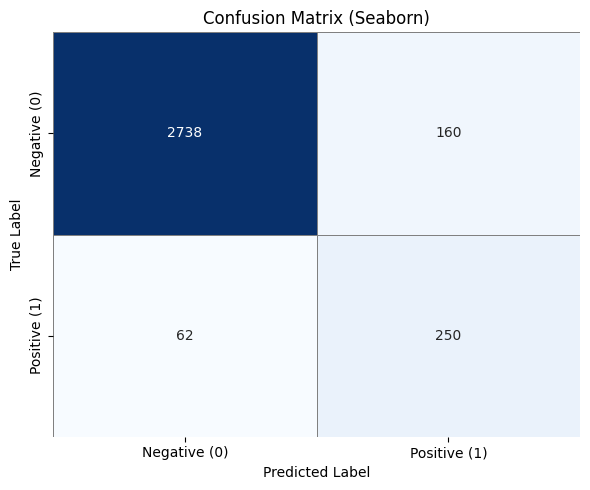

In [47]:
cm = confusion_matrix(y_test, y_test_pred_voting)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

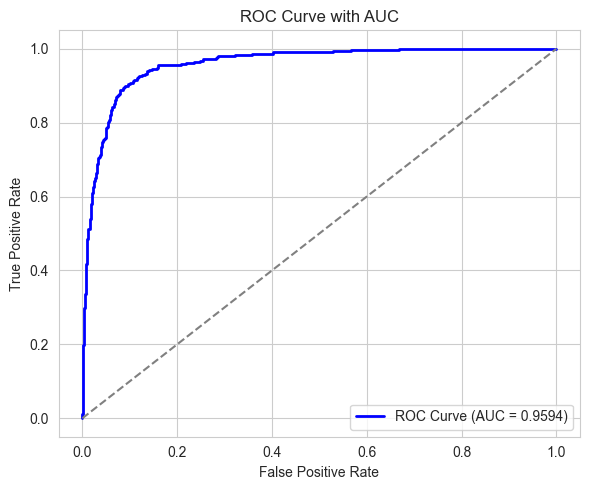

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_voting)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### **Stacking Classifier**

In [49]:
stacking_model = StackingClassifier(
    estimators=[
        ('lr',lr_model),
        ('et', et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)
    
stacking_model.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=0.4575961861747018,
                                                                    class_weight='balanced',
                                                                    n_jobs=-1,
                                                                    random_state=42,
                                                                    solver='liblinear'))])),
                               ('et',
                                ExtraTreesClassifier(class_weight='balanced',
                                                     max_depth=22,
                                                     max_features=None,
                                                     min_samples_split=4,
                                                     n_estimators=427,
                                                     n...
                                LGBMClassifier(colsample_bytree=0.8232593909030717,
                                               learning_rate=0.04025109284446353,
                                               max_depth=12,
                                               min_child_samples=27,
                                               min_split_gain=0.03100742301036102,
                                               n_estimators=420, n_jobs=-1,
                                               num_leaves=186, random_state=42,
                                               reg_alpha=0.6434378829958752,
                                               reg_lambda=0.22211518397241942,
                                               scale_pos_weight=10,
                                               subsample=0.9374216200318296))],
                   final_estimator=LogisticRegression(class_weight='balanced'),
                   n_jobs=-1)

In [50]:
y_test_proba_stacking = stacking_model.predict_proba(X_test)[:, 1]
y_test_pred_stacking  = stacking_model.predict(X_test)

In [51]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_stacking):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_stacking):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_stacking):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_stacking):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_stacking):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba_stacking):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba_stacking):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred_stacking))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred_stacking))

Accuracy: 0.9364
Precision: 0.6687
Recall: 0.6859
F1-score: 0.6772
AUC-ROC: 0.9580
Log loss: 0.1581
Brier score: 0.0479

Confusion matrix:
[[2792  106]
 [  98  214]]

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2898
           1       0.67      0.69      0.68       312

    accuracy                           0.94      3210
   macro avg       0.82      0.82      0.82      3210
weighted avg       0.94      0.94      0.94      3210



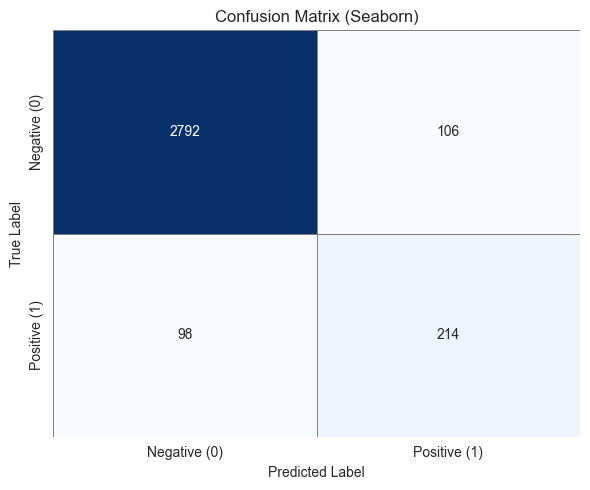

In [52]:
cm = confusion_matrix(y_test, y_test_pred_stacking)
labels = ['Negative (0)', 'Positive (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False)
plt.title("Confusion Matrix (Seaborn)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

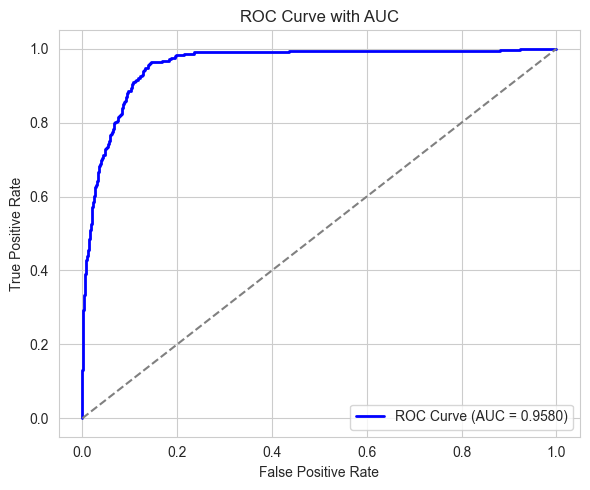

In [53]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with AUC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
